In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../../data/form990_embf.csv', )
df.drop(['Unnamed: 0'], axis=1, inplace=True)

display(df.head())
display(df.shape)


/var/folders/79/jdv69xcs22z7cyxln5rsbzzh0000gn/T/ipykernel_24273/837306774.py:5: DtypeWarning: Columns (14,46,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/form990_embf.csv', )


,efile,ein,tax_pd,subseccd,s501c3or4947a1cd,schdbind,politicalactvtscd,lbbyingactvtscd,subjto6033cd,dnradvisedfundscd,...,grsinc509,unreltxincls511tx509,subtotsuppinc509,netincunrelatd509,othrinc509,totsupp509,activity,ntee_cd,subsection,affiliation
0,P,426057254.0,2011-06-01,2.0,N,N,N,NaN,N,N,...,0.0,0.0,0.0,0.0,0.0,0.0,36399000.0,NaN,2.0,3.0
1,P,60891737.0,2011-10-01,5.0,N,N,N,NaN,N,N,...,0.0,0.0,0.0,0.0,0.0,0.0,232000000.0,K20,5.0,3.0
2,P,660550623.0,2011-12-01,3.0,Y,Y,N,N,N,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S20,3.0,3.0
3,P,464039105.0,2012-06-01,3.0,Y,Y,N,N,N,N,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,P,161696098.0,2012-12-01,3.0,Y,N,N,N,N,N,...,0.0,0.0,0.0,0.0,0.0,121247.0,0.0,T21,3.0,3.0


(302568, 250)

# Financial Research Questions

## 1. What is the mean/median expenses for tax exempt orgs? 

In [135]:
pd.options.mode.chained_assignment = None  # Disable the SettingWithCopyWarning

# Filter dataset to section IX fields from Form 990.
df_expenses = df[[
    'accntingfees', 'advrtpromo', 'benifitsmembrs', 'compnsatncurrofcr',
    'compnsatnandothr', 'converconventmtng', 'deprcatndepletn', 'grntstogovt',
    'grnsttoindiv', 'grntstofrgngovt', 'infotech', 'insurance',
    'feesforsrvcinvstmgmt', 'legalfees', 'feesforsrvclobby', 'feesforsrvcmgmt',
    'occupancy', 'officexpns', 'othremplyeebenef', 'othrexpnsa', 'othrexpnsb',
    'othrexpnsc', 'othrexpnsd', 'othrexpnse', 'othrexpnsf', 'feesforsrvcothr',
    'othrsalwages', 'pymtoaffiliates', 'payrolltx', 'pensionplancontrb',
    'profndraising', 'royaltsexpns', 'totfuncexpns', 'travel',
    'travelofpublicoffcl','lessdirfndrsng']] 

mean_expense = round(df.totfuncexpns.mean())
formatted_mean_expense = "{:,}".format(mean_expense)
print(f"The average total expenses for the 2022 tax exempts is {formatted_mean_expense}")


The average total expenses for the 2022 tax exempts is $9,804,510


## 2. What is the mean/median percentage breakdown of expenses by category? 
* The data omits broader expense categories from Form 990's Section IX, such as total fundraising, administrative, and program specific expenses. Instead, it includes only their detailed subcategories, making it challenging to ascertain their corresponding broader categories. 
* Vis note: think about a bar chart instead of pie chart

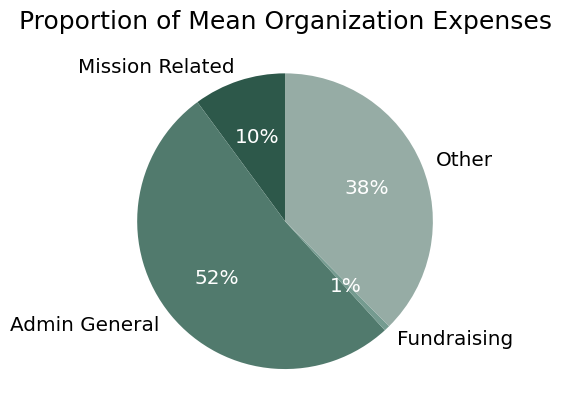

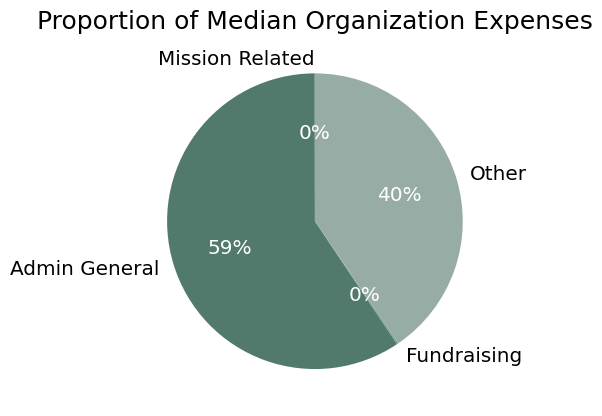

In [136]:
# Sum all fields that may add up to the Total functional expenses field (totfuncexpns)
columns_to_sum = df_expenses.columns.drop(['totfuncexpns','lessdirfndrsng'])
df_expenses.loc[:, 'sum_expenses'] = df_expenses[columns_to_sum].sum(axis=1) 

# Create cols by summing categorical expenses.
df_expenses.loc[:, 'mission_related'] = df_expenses[['grntstogovt','grnsttoindiv','grntstofrgngovt','converconventmtng']].sum(axis=1)
df_expenses.loc[:, 'admin_general'] = df_expenses[['compnsatncurrofcr','officexpns','insurance','occupancy','accntingfees','legalfees','feesforsrvcmgmt','feesforsrvcinvstmgmt','othrsalwages','payrolltx','pensionplancontrb','othremplyeebenef','infotech','compnsatnandothr','travelofpublicoffcl','benifitsmembrs']].sum(axis=1)
df_expenses.loc[:, 'fundraising'] = df_expenses[['profndraising','advrtpromo','lessdirfndrsng']].sum(axis=1)
df_expenses.loc[:, 'other'] = df_expenses[['deprcatndepletn','feesforsrvclobby','pymtoaffiliates','royaltsexpns','travel','infotech','othrexpnsa','othrexpnsb','othrexpnsc','othrexpnsd','othrexpnse','othrexpnsf','feesforsrvcothr']].sum(axis=1)

# What % of sum_expenses = to total expenses
equal_rows = (df_expenses['totfuncexpns'] == df_expenses['sum_expenses']).sum()
total_rows = df_expenses.shape[0]
percentage = round((equal_rows / total_rows) * 100)
#print(f"Percentage of rows where 'totfuncexpns' equals self calculated total expenses: {percentage}%")

#  mean values
mean_mission_exp = df_expenses['mission_related'].mean()
mean_admin_exp = df_expenses['admin_general'].mean()
mean_fundraising_exp = df_expenses['fundraising'].mean()
mean_other_exp = df_expenses['other'].mean()

med_mission_exp = df_expenses['mission_related'].median()
med_admin_exp = df_expenses['admin_general'].median()
med_fundraising_exp = df_expenses['fundraising'].median()
med_other_exp = df_expenses['other'].median()

colors = ['#2D584A', '#517A6D', '#759B90', '#96ACA5'] 

# Create the pie chart
def pie_chart(sizes, labels, statistic):
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.0f%%',
                                    startangle=90, colors=colors, textprops={'size': 'x-large'})
    plt.setp(autotexts, color='white', size='x-large')
    plt.title(f'Proportion of {statistic} Organization Expenses',fontsize=18)
    plt.show()

sizes = [mean_mission_exp, mean_admin_exp, mean_fundraising_exp, mean_other_exp]
labels = ['Mission Related', 'Admin General', 'Fundraising', 'Other']
pie_chart(sizes, labels, 'Mean')

sizes = [med_mission_exp, med_admin_exp, med_fundraising_exp, med_other_exp]
labels = ['Mission Related', 'Admin General', 'Fundraising', 'Other']
pie_chart(sizes, labels, 'Median')

## 3. What is the mean/median total revenue for tax exempt orgs? 

In [137]:
pd.options.mode.chained_assignment = None  # Disable the SettingWithCopyWarning

# Filter dataset to section IX fields from Form 990.
df_revenue = df[['totrevenue','totprgmrevnue','miscrevtot11e','totcntrbgfts']] 

mean_revenue = round(df.totrevenue.mean())
formatted_mean_revenue = "{:,}".format(mean_revenue)
print(f"The average total revenue for the 2022 tax exempts is ${formatted_mean_revenue}")


The average total revenue for the 2022 tax exempts is $11,030,154


## 4. What is the mean/median percentage breakdown of revenue by category? 
* Vis note: think about a bar chart instead of pie chart


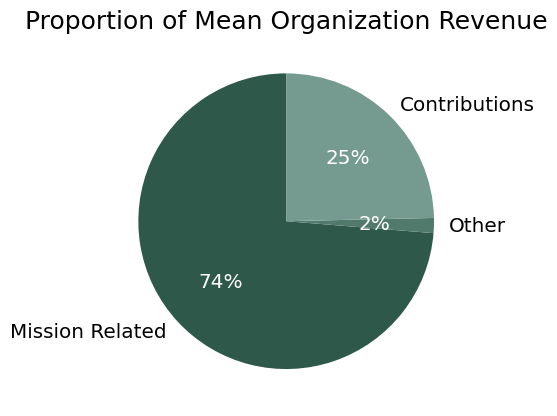

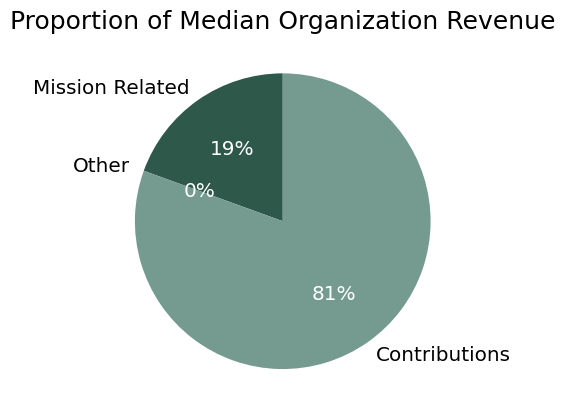

In [140]:
#  mean values
mean_program_rev = df_revenue['totprgmrevnue'].mean()
mean_other_rev = df_revenue['miscrevtot11e'].mean()
mean_contribution_rev = df_revenue['totcntrbgfts'].mean()

med_program_rev = df_revenue['totprgmrevnue'].median()
med_other_rev = df_revenue['miscrevtot11e'].median()
med_contribution_rev = df_revenue['totcntrbgfts'].median()

colors = ['#2D584A', '#517A6D', '#759B90', '#96ACA5'] 

# Create the pie chart
def pie_chart(sizes, labels, statistic):
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.0f%%',
                                    startangle=90, colors=colors, textprops={'size': 'x-large'})
    plt.setp(autotexts, color='white', size='x-large')
    plt.title(f'Proportion of {statistic} Organization Revenue',fontsize=18)
    plt.show()

sizes = [mean_program_rev, mean_other_rev, mean_contribution_rev]
labels = ['Mission Related', 'Other', 'Contributions']
pie_chart(sizes, labels, 'Mean')

sizes = [med_program_rev, med_other_rev, med_contribution_rev]
labels = ['Mission Related', 'Other', 'Contributions']
pie_chart(sizes, labels, 'Median')

# Impact

## 1. What proportion of nonprofits engage in grantmaking, and what are their patterns of distribution?

In [65]:
df_grants_binary = df[['rptgrntstoindvcd','rptgrntstogovtcd']]

df_grants_binary = df_grants_binary[(df_grants_binary['rptgrntstoindvcd']=='Y') | (df_grants_binary['rptgrntstogovtcd']=='Y')]
orgs_that_grant = df_grants_binary.value_counts().sum()
total_orgs = df.shape[0]
proportion = (orgs_that_grant / total_orgs)*100
print(f"{proportion}% of nonprofits engage in grantmaking")

21.237209486793052% of nonprofits engage in grantmaking


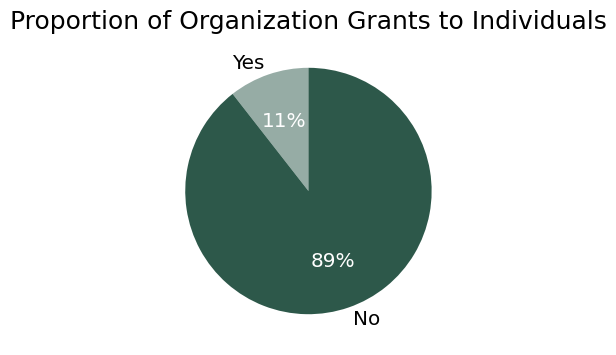

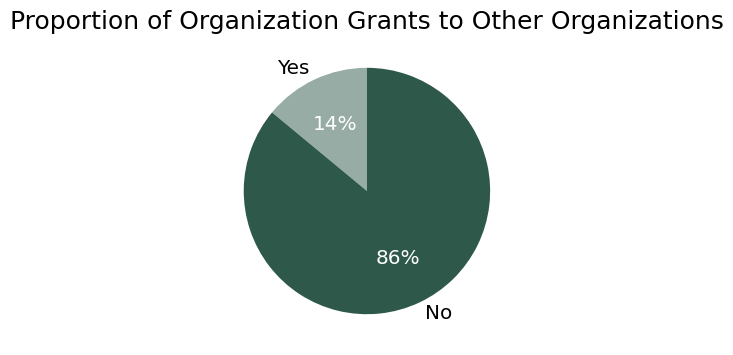

In [8]:
in_grants_ct = df['rptgrntstoindvcd'].value_counts()


Individuals = df['rptgrntstoindvcd'].value_counts().loc[['Y', 'N']]
Organizations = df['rptgrntstogovtcd'].value_counts().loc[['Y', 'N']]

custom_labels = ['Yes', 'No']
labels_ordered = [custom_labels[i] for i in range(len(in_grants_ct))]

pichart_dfs = [Individuals, Organizations]
labels = ['Grants to Individuals', 'Grants to Other Organizations']

# Generate pie charts
for data, label in zip(pichart_dfs, labels):
    plt.figure(figsize=(6, 4))
    _, _, autotexts = plt.pie(data, labels=custom_labels, autopct='%1.0f%%', startangle=90, colors=['#96ACA5', '#2D584A'], textprops={'size': 'x-large'})
    for ins in autotexts:
        ins.set_color('white')
    plt.title(f'Proportion of Organization {label}', fontsize=18)
    plt.show()

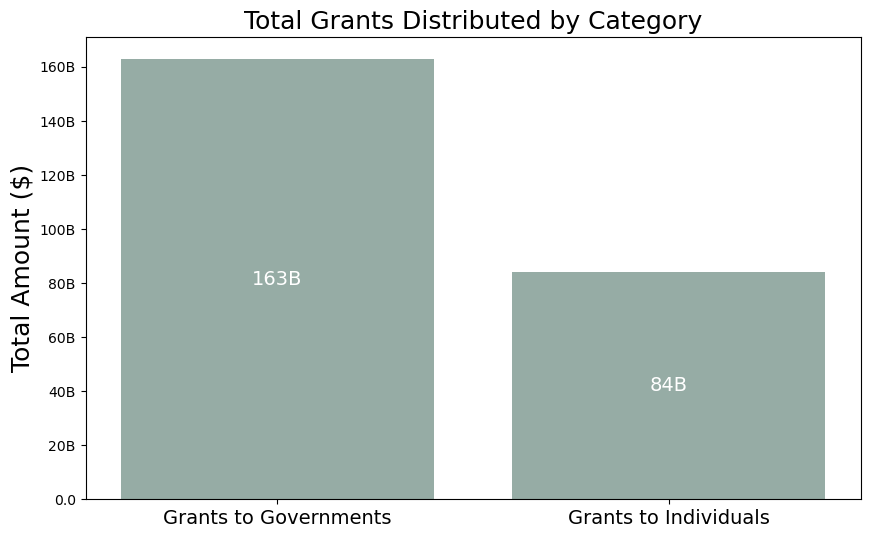

In [19]:
# Create function for abreviated value labels.
from matplotlib.ticker import FuncFormatter

def human_readable(x, pos):
    if x >= 1e12:  # Trillions
        s = f'{x / 1e12:.0f}T'
    elif x >= 1e9:  # Billions
        s = f'{x / 1e9:.0f}B'
    elif x >= 1e6:  # Millions
        s = f'{x / 1e6:.0f}M'
    elif x >= 1e3:  # Thousands
        s = f'{x / 1e3:.0f}K'
    else:
        s = str(x)
    return s
formatter = FuncFormatter(human_readable)

categories = ['Grants to Governments', 'Grants to Individuals']
values = [df['grntstogovt'].sum(), df['grnsttoindiv'].sum()]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color='#96ACA5')

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{human_readable(yval, None)}',  # Use human_readable for label
             ha='center', va='center', color='white', fontsize=14)

plt.title('Total Grants Distributed by Category',fontsize=18)
plt.ylabel('Total Amount ($)',fontsize=18)
plt.xticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

## 2. What is the impact of the programs run by these organizations, and how effectively are they using their funds?
      1. Comes from Section III in the form but the IRS extract lacks this info. What's the best way to look into this?

3. Temporal:
   1. How financially stable are philanthropic organizations over time?